# Lab 2  - Image Processing

### Names:
#### Spencer Bernardo-Cheng, Rob Keehan, Max Goldstein

In [108]:
import pandas as pd
import numpy as np
import glob
import cv2
# stack overflow example taken from: https://stackoverflow.com/questions/37747021/create-numpy-array-of-images
X_data = []
Y_data = []

files = glob.glob ("./cell_images/Parasitized/*.png")
for myFile in range(0,5000):
    image = cv2.imread(files[myFile],cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image,(135,135))
    X_data.append(image)
    Y_data.append(1)
files = glob.glob ("./cell_images/Uninfected/*.png")
for myFile in range(0,5000):
    image = cv2.imread(files[myFile],cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image,(135,135))
    X_data.append (image)
    Y_data.append(0)
npArr =np.array(X_data)
print('X_data shape:', np.array(X_data).shape)

X_data shape: (10000, 135, 135)


## Linearizing the images into a 1-d numpy array

In [109]:
print(npArr[0].shape)
print(npArr[1].shape)
pixels = npArr.flatten().reshape(10000,18225)
pixels.shape

(135, 135)
(135, 135)


(10000, 18225)

In [110]:
print(pixels.shape)

(10000, 18225)


In [111]:
Y_data = np.array(Y_data)
h=135
w=135

## Visualizing the images

In [112]:
from matplotlib import pyplot as plt

# a helper plotting function

def plot_gallery(images, titles, h, w,n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h,w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(pixels, Y_data, h, w) # defaults to showing a 3 by 6 subset of the faces


In [113]:
# manipulated from Sebastian Raschka Example (your book!)
# also from hi blog here: http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html


def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Bar, Line
    from plotly.graph_objs import Scatter, Layout
    from plotly.graph_objs.scatter import Marker
    from plotly.graph_objs.layout import XAxis, YAxis
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })
        


## Linear Dimemensionsality Reduction using PCA

In [7]:
# lets do some PCA of the features and go from 1850 features to 20 features
from sklearn.decomposition import PCA

n_components = 300
print ("Extracting the top %d eigenfaces from %d faces" % (
    n_components, npArr.shape[0]))

pca = PCA(n_components=n_components)
%time pca.fit(pixels.copy())


Extracting the top 300 eigenfaces from 27558 faces


KeyboardInterrupt: 

In [ ]:
plot_explained_variance(pca)

In [ ]:
eigenfaces = pca.components_.reshape((n_components, h, w))
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

In [ ]:
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image
    
idx_to_reconstruct = 4    
X_idx = pixels[idx_to_reconstruct]
low_dimensional_representation, reconstructed_image = reconstruct_image(pca,X_idx.reshape(1, -1))

In [ ]:
plt.subplot(1,2,1)
plt.imshow(X_idx.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Original')
plt.grid(False)
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Reconstructed from Full PCA')
plt.grid(False)

## Daisy 

<p> This is a visualization of what DAISY feature reducation looks like on one of our images. It covers the most of the image should not miss any important features of the image. </p>

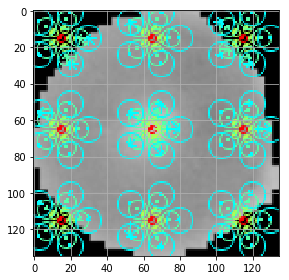

In [166]:
from skimage.feature import daisy

# lets first visualize what the daisy descripto looks like
features, img_desc = daisy(img, 
                           step=50, 
                           radius=15, 
                           rings=3, 
                           histograms=5, 
                           orientations=8, 
                           visualize=True)
imshow(img_desc)
plt.grid()
plt.show()

In [167]:
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape),
                 step=50, 
                   radius=15, 
                   rings=3, 
                   histograms=5, 
                   orientations=8, 
                   visualize=False)
    return feat.reshape((-1))

%time test_feature = apply_daisy(pixels[3],(h,w))
test_feature.shape

CPU times: user 56.6 ms, sys: 9.75 ms, total: 66.4 ms
Wall time: 64 ms


(1152,)

<p> This just tells us how long it will take to get all the daisy features. </p>

In [168]:
0.0614 * len(pixels)

614.0

In [169]:
%time daisy_features = np.apply_along_axis(apply_daisy, 1, pixels, (h,w))
print(daisy_features.shape)

CPU times: user 6min 16s, sys: 35.1 s, total: 6min 51s
Wall time: 6min 53s
(10000, 1152)


In [170]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(daisy_features, n_jobs=4)

CPU times: user 2.47 s, sys: 9.52 s, total: 12 s
Wall time: 19.7 s


<p> We built a KNN classifier on the daisy feature set and a KNN classifier on the pixels as features to test the difference between the accuracy of the two and timing. </p>

In [171]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)

<p> The KNN classifier on the daisy feature set. </p>

In [172]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(daisy_features, Y_data, test_size = 1/10, random_state = 0)

In [173]:
%time knn.fit(xTrain, yTrain)

CPU times: user 635 ms, sys: 10.4 ms, total: 645 ms
Wall time: 643 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [174]:
%time predictions = knn.predict(xTest)

CPU times: user 15.4 s, sys: 28.1 ms, total: 15.4 s
Wall time: 15.4 s


In [175]:
from sklearn.metrics import accuracy_score
print('KNN with daisy features has an accuracy of',accuracy_score(yTest, predictions))

KNN with daisy features has an accuracy of 0.599


<p> The KNN Classifier being trained on the pixels as features. </p>

In [176]:
xTrain, xTest, yTrain, yTest = train_test_split(pixels, Y_data, test_size = 1/10, random_state = 0)

In [177]:
%time knn.fit(xTrain, yTrain)

CPU times: user 17 s, sys: 602 ms, total: 17.6 s
Wall time: 17.7 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [178]:
%time predictions = knn.predict(xTest)

CPU times: user 4min 20s, sys: 1.22 s, total: 4min 21s
Wall time: 4min 22s


In [179]:
print('KNN with pixels as features has an accuracy of',accuracy_score(yTest, predictions))

KNN with pixels as features has an accuracy of 0.609


In [181]:
pixels.shape

(10000, 18225)

In [182]:
daisy_features.shape

(10000, 1152)

<p> DAISY feature extraction shows some promise as it only caused a loss of 1 percent in accuracy. It reduced the amount of features from  18225 to 1152. It lowered the runtime for fitting the data from 17.7 seconds to 0.643 seconds. Also, it lowered the prediction time from 262 seconds to 15.4 seconds. It may be difficult to tell if DAISY is truly a great way of reducing features as both our KNN classifiers are highly inaccurate, but it does reduce the training and prediction timings. We would advise using DAISY feature extraction as you only lose 1 percent of accuracy and greatly reduce the runtime of training and predicting with a KNN classifier.  </p>

<p>Below, we show two images and their closest images based off DAISY. We can see that it struggles to produce an image that is similar to the original. Also, we can see sometimes the closest image is of a different classification. </p>

Class 1


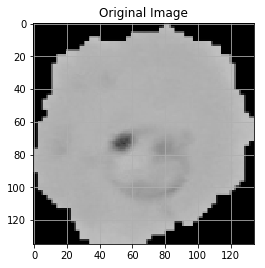

Class 0


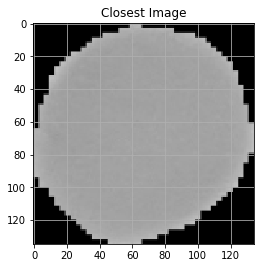

Class 1


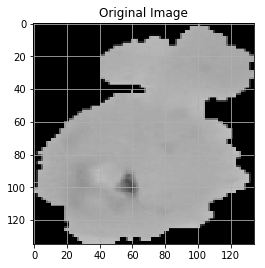

Class 1


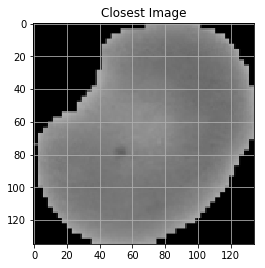

In [184]:
import copy
# find closest image to current image
for i in range(0,2):
    idx1 = i 
    distances = copy.deepcopy(dist_matrix[idx1,:])
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)
    print('Class',Y_data[idx1])
    plt.figure(figsize=(7,10))
    plt.subplot(1,2,1)
    imshow(pixels[idx1].reshape((h,w)))
    plt.title("Original Image")
    plt.grid()
    plt.show()
    print('Class',Y_data[idx2])
    plt.figure(figsize=(7,10))
    plt.subplot(1,2,2)
    imshow(pixels[idx2].reshape((h,w)))
    plt.title("Closest Image")
    plt.grid()
    plt.show()